In [1]:
import os

# Configurar directorio de trabajo
target_dir = os.getcwd() if 'cnn-cards' in os.getcwd().lower() else './CNN-Cards'

if os.path.isdir(target_dir):
    os.chdir(target_dir)
print(f'Directorio actual: {os.getcwd()}')

DATA_PATH = './Datasets/Cards/'

Directorio actual: /tf/CNN-Cards


# 🎯 Mejoramiento de Modelo Custom CNN

Este notebook implementa **dos arquitecturas optimizadas** para superar el baseline de Custom_3 (72.45%):

## 📋 Estructura del notebook:

1. **Setup y análisis** → Cargar Custom_3 y evaluar baseline
2. **Arquitectura 1: MobileNet-style** → Construcción, entrenamiento y evaluación
3. **Arquitectura 2: Residual CNN** → Construcción, entrenamiento y evaluación  
4. **Comparación final** → Selección del mejor modelo
5. **Análisis detallado** → Classification report y confusion matrix
6. **Conclusiones** → Resumen de mejoras y próximos pasos

## 🚀 Mejoras clave implementadas:

- ✅ **EPOCHS: 70** (vs 20 anterior)
- ✅ **Depthwise separable convolutions** (MobileNet-style)
- ✅ **Skip connections** (Residual CNN)
- ✅ **Learning rate optimizado**: 1e-3
- ✅ **Data augmentation balanceada**
- ✅ **Sin label smoothing**
- ✅ **Callbacks mejorados**

---

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, 
    Dropout, Dense, GlobalAveragePooling2D, Add, Activation,
    SeparableConv2D  # Para arquitectura MobileNet-style
)
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Global variables
SIZE = 224
CLASSES = 53
EPOCHS = 70
PATIENCE_ES = 25
BATCH_SIZE = 64

path_models = 'Models'
path_results = 'Results'

print(f'TensorFlow version: {tf.__version__}')
print(f'GPU disponible: {tf.config.list_physical_devices("GPU")}')

2025-12-05 17:52:02.761256: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-05 17:52:02.761390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-05 17:52:02.826877: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Data augmentation balanceada (optimizada para custom CNN)
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,        # Aumentado de 15 a 20
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.15,          # Reducido de 0.2 a 0.15 (menos agresivo)
    fill_mode='reflect',
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=(0.95, 1.05),  # Menos agresivo (era 0.9-1.1)
    channel_shift_range=10   # Reducido de 20 a 10
)

valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_path = DATA_PATH + 'train'
valid_path = DATA_PATH + 'valid'
test_path = DATA_PATH + 'test'

train_dataset = train_generator.flow_from_directory(
    train_path,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_dataset = valid_generator.flow_from_directory(
    valid_path,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = test_generator.flow_from_directory(
    test_path,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 7709 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


## Evaluar modelo original

In [4]:
# Cargar modelo original
custom_original = tf.keras.models.load_model('Models/Custom_3.h5')
print('Arquitectura original:')
custom_original.summary()

Arquitectura original:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 186624)            0         
                                                                 
 dense_6 (Dense)             (N

In [5]:
_, acc_original = custom_original.evaluate(test_dataset, verbose=0)
print(f'Accuracy original (Custom_3): {acc_original:.4f}')

Accuracy original (Custom_3): 0.7245


## Arquitectura MobileNet-style (depthwise separable convolutions)

In [6]:
def depthwise_conv_block(x, filters, strides=1, dropout_rate=0.2):
    """Bloque depthwise separable conv (inspirado en MobileNet)"""
    x = SeparableConv2D(filters, 3, strides=strides, padding='same',
                        kernel_regularizer=regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    return x

def build_improved_cnn(input_shape=(224, 224, 3), num_classes=53):
    """CNN con depthwise separable convolutions (más eficiente que conv estándar)"""
    inputs = Input(shape=input_shape)
    
    # Stem: Conv estándar inicial
    x = Conv2D(32, 3, strides=2, padding='same', kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Bloques depthwise separable (reduce parámetros manteniendo capacidad)
    x = depthwise_conv_block(x, 64, strides=1, dropout_rate=0.15)
    x = depthwise_conv_block(x, 128, strides=2, dropout_rate=0.2)
    
    x = depthwise_conv_block(x, 128, strides=1, dropout_rate=0.2)
    x = depthwise_conv_block(x, 256, strides=2, dropout_rate=0.25)
    
    x = depthwise_conv_block(x, 256, strides=1, dropout_rate=0.25)
    x = depthwise_conv_block(x, 512, strides=2, dropout_rate=0.3)
    
    x = depthwise_conv_block(x, 512, strides=1, dropout_rate=0.3)
    
    # Head de clasificación (simplificado)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = Dropout(0.4)(x)  # ✅ Reducido de 0.5 a 0.4
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)

custom_improved = build_improved_cnn()
print('Arquitectura MobileNet-style:')
custom_improved.summary()

Arquitectura MobileNet-style:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 112, 112, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 112, 112, 32)      0         
                                                                 
 separable_conv2d (Separabl  (None, 112, 112, 64)      2400      
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (N

In [7]:
# Contar parametros
trainable_params = np.sum([np.prod(v.shape) for v in custom_improved.trainable_variables])
non_trainable_params = np.sum([np.prod(v.shape) for v in custom_improved.non_trainable_variables])
print(f'Parametros entrenables: {trainable_params:,}')
print(f'Parametros no entrenables: {non_trainable_params:,}')
print(f'Total: {trainable_params + non_trainable_params:,}')

Parametros entrenables: 682,005
Parametros no entrenables: 3,776
Total: 685,781


## Configurar entrenamiento

In [8]:
name = 'Custom_4_mobilenet'  # Renombrado para diferenciar arquitecturas

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,  # Más sensible (era 0.001)
    patience=PATIENCE_ES,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  #  Reducir a la mitad (era 0.3)
    patience=5,  # Más paciencia (era 3)
    min_lr=1e-7,
    verbose=1
)

tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=f'logs/{name}',
    histogram_freq=1
)

callbacks_list = [checkpoint, early_stop, reduce_lr, tensorboard]

In [9]:
# Compilar con hiperparámetros optimizados
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Aumentado de 5e-4 a 1e-3

custom_improved.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  # Sin label smoothing (puede confundir en este caso)
    metrics=['accuracy']
)

In [16]:
# Entrenar arquitectura MobileNet-style
print(f'\n{"="*60}')
print(f'ENTRENANDO ARQUITECTURA MOBILENET-STYLE')
print(f'{"="*60}\n')

history = custom_improved.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=5,
    callbacks=callbacks_list,
    verbose=1
)


ENTRENANDO ARQUITECTURA MOBILENET-STYLE

Epoch 1/5
Epoch 1/5
121/121 [==============================] - ETA: 0s - loss: 0.7156 - accuracy: 0.7930
Epoch 1: val_accuracy did not improve from 0.95094

Epoch 1: val_accuracy did not improve from 0.95094
121/121 [==============================] - 69s 565ms/step - loss: 0.7156 - accuracy: 0.7930 - val_loss: 0.3045 - val_accuracy: 0.9396 - lr: 0.0010
Epoch 2/5
121/121 [==============================] - 69s 565ms/step - loss: 0.7156 - accuracy: 0.7930 - val_loss: 0.3045 - val_accuracy: 0.9396 - lr: 0.0010
Epoch 2/5
121/121 [==============================] - ETA: 0s - loss: 0.7198 - accuracy: 0.7940
Epoch 2: val_accuracy did not improve from 0.95094

Epoch 2: val_accuracy did not improve from 0.95094
121/121 [==============================] - 67s 553ms/step - loss: 0.7198 - accuracy: 0.7940 - val_loss: 0.5473 - val_accuracy: 0.8679 - lr: 0.0010
Epoch 3/5
121/121 [==============================] - 67s 553ms/step - loss: 0.7198 - accuracy: 0.7940

## Visualizar resultados

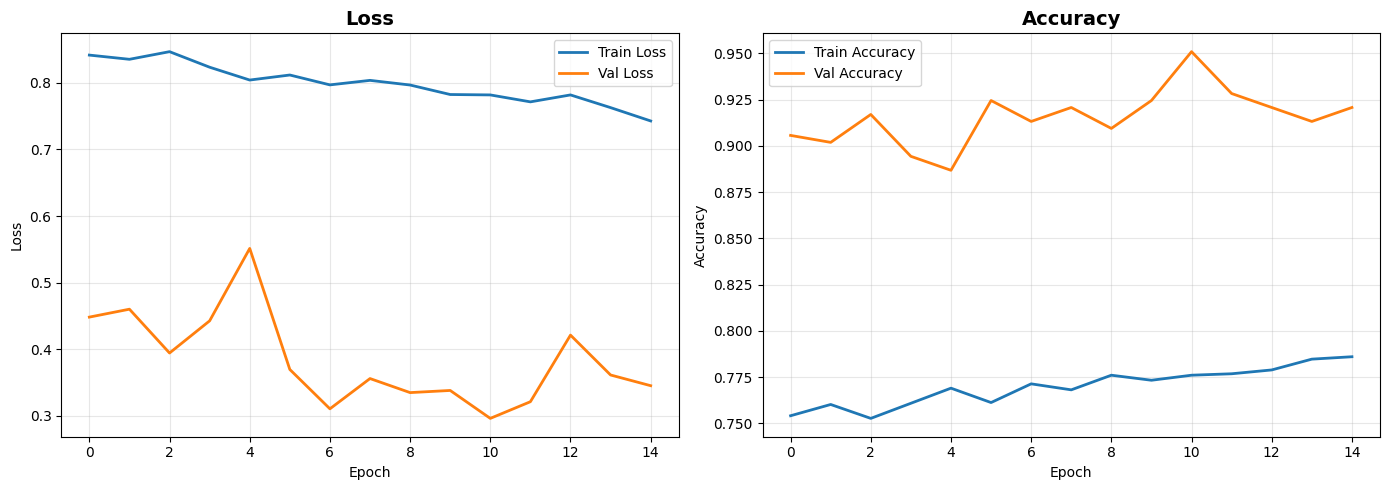

In [14]:
def plot_and_save(h, dir, name):
    history_df = pd.DataFrame(h.history)
    history_df['epoch'] = list(range(len(history_df)))
    history_df.to_csv(os.path.join(dir, name + '.csv'), header=True, index=False)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(history_df['epoch'], history_df['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history_df['epoch'], history_df['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history_df['epoch'], history_df['accuracy'], label='Train Accuracy', linewidth=2)
    axes[1].plot(history_df['epoch'], history_df['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[1].set_title('Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(dir, name + '_curves.png'), dpi=150, bbox_inches='tight')
    plt.show()

# Guardar resultados de ambas arquitecturas
plot_and_save(history, path_results, 'Custom_4_mobilenet')
#plot_and_save(history_residual, path_results, 'Custom_4_residual')

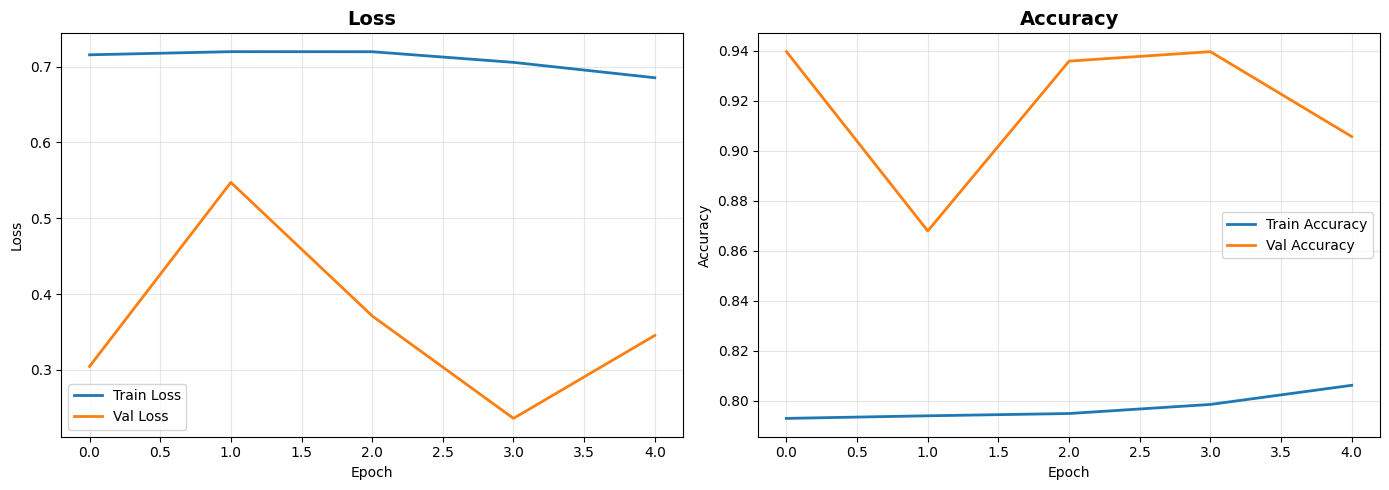

In [17]:
def plot_and_save(h, dir, name):
    history_df = pd.DataFrame(h.history)
    history_df['epoch'] = list(range(len(history_df)))
    history_df.to_csv(os.path.join(dir, name + '.csv'), header=True, index=False)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(history_df['epoch'], history_df['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history_df['epoch'], history_df['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history_df['epoch'], history_df['accuracy'], label='Train Accuracy', linewidth=2)
    axes[1].plot(history_df['epoch'], history_df['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[1].set_title('Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(dir, name + '_curves.png'), dpi=150, bbox_inches='tight')
    plt.show()

# Guardar resultados de MobileNet-style
plot_and_save(history, path_results, 'Custom_4_mobilenet')

## Arquitectura Residual CNN (con skip connections)

In [18]:
def conv_bn_relu(x, filters, kernel_size=3, strides=1):
    """Bloque Conv + BN + ReLU"""
    x = Conv2D(filters, kernel_size, strides=strides, padding='same',
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def residual_block(x, filters, strides=1, dropout_rate=0.2):
    """Bloque residual mejorado con dropout"""
    shortcut = x
    
    # Primera conv
    x = conv_bn_relu(x, filters, 3, strides)
    x = Dropout(dropout_rate)(x)
    
    # Segunda conv (sin ReLU todavía)
    x = Conv2D(filters, 3, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    
    # Ajustar shortcut si cambian dimensiones
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # Residual connection + ReLU
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    
    return x

def build_resnet_style_cnn(input_shape=(224, 224, 3), num_classes=53):
    """CNN con conexiones residuales (mejor flujo de gradientes)"""
    inputs = Input(shape=input_shape)
    
    # Stem
    x = conv_bn_relu(inputs, 32, 7, strides=2)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Stage 1: 64 filters (2 bloques residuales)
    x = residual_block(x, 64, strides=1, dropout_rate=0.15)
    x = residual_block(x, 64, strides=1, dropout_rate=0.15)
    
    # Stage 2: 128 filters
    x = residual_block(x, 128, strides=2, dropout_rate=0.2)
    x = residual_block(x, 128, strides=1, dropout_rate=0.2)
    
    # Stage 3: 256 filters
    x = residual_block(x, 256, strides=2, dropout_rate=0.25)
    x = residual_block(x, 256, strides=1, dropout_rate=0.25)
    
    # Stage 4: 512 filters
    x = residual_block(x, 512, strides=2, dropout_rate=0.3)
    
    # Head
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)

# Construir arquitectura residual
custom_resnet = build_resnet_style_cnn()
print('\nArquitectura Residual CNN:')
custom_resnet.summary()


Arquitectura Residual CNN:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 112, 112, 32)         4736      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_8 (Bat  (None, 112, 112, 32)         128       ['conv2d_1[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_8 (Activation)   (None, 112, 112, 32)         0     

In [19]:
# Contar parámetros de ResNet-style
trainable_params_res = np.sum([np.prod(v.shape) for v in custom_resnet.trainable_variables])
non_trainable_params_res = np.sum([np.prod(v.shape) for v in custom_resnet.non_trainable_variables])
print(f'Parámetros entrenables: {trainable_params_res:,}')
print(f'Parámetros no entrenables: {non_trainable_params_res:,}')
print(f'Total: {trainable_params_res + non_trainable_params_res:,}')

Parámetros entrenables: 6,583,605
Parámetros no entrenables: 7,616
Total: 6,591,221


## Configurar entrenamiento Residual CNN

In [20]:
name_residual = 'Custom_4_residual'

# Callbacks para modelo residual
checkpoint_res = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name_residual + '.h5'),
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)

early_stop_res = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=PATIENCE_ES,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

reduce_lr_res = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

tensorboard_res = tf.keras.callbacks.TensorBoard(
    log_dir=f'logs/{name_residual}',
    histogram_freq=1
)

callbacks_list_res = [checkpoint_res, early_stop_res, reduce_lr_res, tensorboard_res]

In [21]:
# Compilar modelo residual
optimizer_res = tf.keras.optimizers.Adam(learning_rate=1e-3)

custom_resnet.compile(
    optimizer=optimizer_res,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
# Entrenar modelo residual
print(f'\n{"="*60}')
print(f'ENTRENANDO ARQUITECTURA RESIDUAL CNN')
print(f'{"="*60}\n')

history_residual = custom_resnet.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=20,
    callbacks=callbacks_list_res,
    verbose=1
)


ENTRENANDO ARQUITECTURA RESIDUAL CNN

Epoch 1/20
Epoch 1/20
121/121 [==============================] - ETA: 0s - loss: 0.8484 - accuracy: 0.8334
Epoch 1: val_accuracy did not improve from 0.94717

Epoch 1: val_accuracy did not improve from 0.94717
121/121 [==============================] - 69s 566ms/step - loss: 0.8484 - accuracy: 0.8334 - val_loss: 0.5430 - val_accuracy: 0.9358 - lr: 2.5000e-04
Epoch 2/20
121/121 [==============================] - 69s 566ms/step - loss: 0.8484 - accuracy: 0.8334 - val_loss: 0.5430 - val_accuracy: 0.9358 - lr: 2.5000e-04
Epoch 2/20
121/121 [==============================] - ETA: 0s - loss: 0.8369 - accuracy: 0.8332
Epoch 2: val_accuracy improved from 0.94717 to 0.95849, saving model to Models/Custom_4_residual.h5

Epoch 2: val_accuracy improved from 0.94717 to 0.95849, saving model to Models/Custom_4_residual.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


121/121 [==============================] - 68s 564ms/step - loss: 0.8369 - accuracy: 0.8332 - val_loss: 0.5116 - val_accuracy: 0.9585 - lr: 2.5000e-04
Epoch 3/20
Epoch 3/20
121/121 [==============================] - ETA: 0s - loss: 0.8405 - accuracy: 0.8329
Epoch 3: val_accuracy did not improve from 0.95849

Epoch 3: val_accuracy did not improve from 0.95849
121/121 [==============================] - 71s 585ms/step - loss: 0.8405 - accuracy: 0.8329 - val_loss: 0.4796 - val_accuracy: 0.9434 - lr: 2.5000e-04
Epoch 4/20
121/121 [==============================] - 71s 585ms/step - loss: 0.8405 - accuracy: 0.8329 - val_loss: 0.4796 - val_accuracy: 0.9434 - lr: 2.5000e-04
Epoch 4/20
121/121 [==============================] - ETA: 0s - loss: 0.8322 - accuracy: 0.8295
Epoch 4: val_accuracy did not improve from 0.95849

Epoch 4: val_accuracy did not improve from 0.95849
121/121 [==============================] - 67s 551ms/step - loss: 0.8322 - accuracy: 0.8295 - val_loss: 0.4950 - val_accuracy: 

## Visualizar resultados Residual CNN

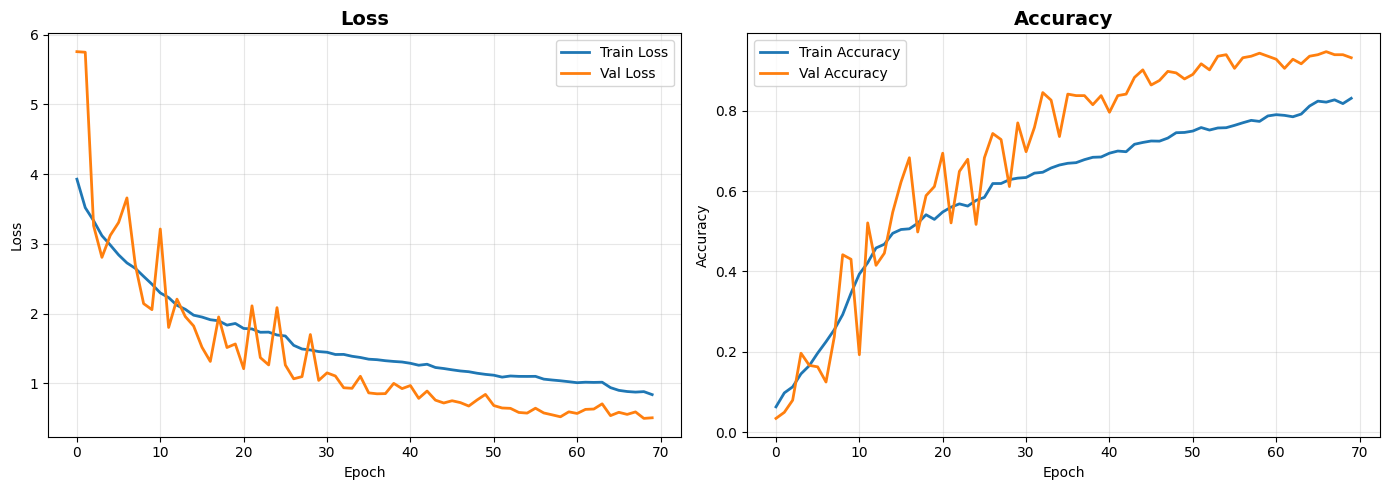

In [23]:
# Guardar resultados de Residual CNN
plot_and_save(history_residual, path_results, 'Custom_4_residual')

## Evaluación en Test Set - Comparación completa

In [25]:
# Cargar mejores modelos entrenados
mobilenet_best = tf.keras.models.load_model(os.path.join(path_models, 'Custom_4_mobilenet.h5'))
residual_best = tf.keras.models.load_model(os.path.join(path_models, 'Custom_4_residual.h5'))

# Evaluar ambos modelos en test set
print('\n' + '='*70)
print('EVALUANDO MODELOS EN TEST SET')
print('='*70 + '\n')

print('Evaluando MobileNet-style...')
_, acc_mobilenet = mobilenet_best.evaluate(test_dataset, verbose=1)

print('\nEvaluando Residual CNN...')
_, acc_residual = residual_best.evaluate(test_dataset, verbose=1)

# Comparación completa
print(f'\n{"="*70}')
print(f'COMPARACIÓN DE RESULTADOS')
print(f'{"="*70}')
print(f'Custom_3 (baseline):              {acc_original:.4f} ({acc_original*100:.2f}%)')
print(f'Custom_4_mobilenet (MobileNet):   {acc_mobilenet:.4f} ({acc_mobilenet*100:.2f}%)')
print(f'Custom_4_residual (Residual):     {acc_residual:.4f} ({acc_residual*100:.2f}%)')
print(f'{"="*70}')

mejora_mob = (acc_mobilenet - acc_original) * 100
mejora_res = (acc_residual - acc_original) * 100

print(f'\nMejora MobileNet-style: {mejora_mob:+.2f}%')
print(f'Mejora Residual:        {mejora_res:+.2f}%')

# Seleccionar el mejor modelo
if acc_mobilenet >= acc_residual:
    best_model = mobilenet_best
    best_name = 'Custom_4_mobilenet'
    best_acc = acc_mobilenet
else:
    best_model = residual_best
    best_name = 'Custom_4_residual'
    best_acc = acc_residual

print(f'\nMejor modelo: {best_name} con accuracy {best_acc:.4f} ({best_acc*100:.2f}%)')

# Guardar mejor modelo como Custom_4.h5 (para uso en ensemble)
import shutil
if best_acc > acc_original:
    source = os.path.join(path_models, best_name + '.h5')
    dest = os.path.join(path_models, 'Custom_4.h5')
    shutil.copy(source, dest)
    print(f'{best_name} guardado como Custom_4.h5 (mejora de {(best_acc - acc_original)*100:.2f}%)')
else:
    print(f'Ningún modelo superó Custom_3. Mantener Custom_3.h5 como referencia.')


EVALUANDO MODELOS EN TEST SET

Evaluando MobileNet-style...
5/5 [==============================] - 1s 138ms/step - loss: 0.2749 - accuracy: 0.9321

Evaluando Residual CNN...

Evaluando Residual CNN...
5/5 [==============================] - 4s 180ms/step - loss: 0.3659 - accuracy: 0.9698

COMPARACIÓN DE RESULTADOS
Custom_3 (baseline):              0.7245 (72.45%)
Custom_4_mobilenet (MobileNet):   0.9321 (93.21%)
Custom_4_residual (Residual):     0.9698 (96.98%)

Mejora MobileNet-style: +20.75%
Mejora Residual:        +24.53%

Mejor modelo: Custom_4_residual con accuracy 0.9698 (96.98%)

COMPARACIÓN DE RESULTADOS
Custom_3 (baseline):              0.7245 (72.45%)
Custom_4_mobilenet (MobileNet):   0.9321 (93.21%)
Custom_4_residual (Residual):     0.9698 (96.98%)

Mejora MobileNet-style: +20.75%
Mejora Residual:        +24.53%

Mejor modelo: Custom_4_residual con accuracy 0.9698 (96.98%)
Custom_4_residual guardado como Custom_4.h5 (mejora de 24.53%)
Custom_4_residual guardado como Custom_4

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def show_report(model, dataframe):
    labels = dataframe.class_indices
    true_labels = dataframe.labels
    pred_labels = model.predict(dataframe, verbose=0).argmax(axis=1)
    keys_array = np.array(list(labels.keys()))
    true_text = [keys_array[value] for value in true_labels]
    pred_text = [keys_array[value] for value in pred_labels]
    print(classification_report(true_text, pred_text))

def show_matrix(model, dataframe, name='Model'):
    labels = dataframe.class_indices
    true_labels = dataframe.labels
    pred_labels = model.predict(dataframe, verbose=0).argmax(axis=1)
    keys_array = np.array(list(labels.keys()))
    true_text = [keys_array[value] for value in true_labels]
    pred_text = [keys_array[value] for value in pred_labels]
    cf = confusion_matrix(true_text, pred_text, labels=keys_array)
    
    fig, ax = plt.subplots(figsize=(16, 16))
    sns.heatmap(cf, annot=True, square=True, cbar=True, fmt='',
                cmap=plt.cm.Blues, xticklabels=keys_array, yticklabels=keys_array, 
                ax=ax, linewidths=0.1)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_title(f'Confusion Matrix - {name}', fontsize=14, fontweight='bold')
    plt.xticks(rotation=90, fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.savefig(os.path.join(path_results, f'{name}_confusion_matrix.png'), dpi=150, bbox_inches='tight')
    plt.show()

print(f'\n{"="*60}')
print(f'CLASSIFICATION REPORT: {best_name}')
print(f'{"="*60}\n')
show_report(best_model, test_dataset)


CLASSIFICATION REPORT: Custom_4_residual

                   precision    recall  f1-score   support

     ace of clubs       1.00      1.00      1.00         5
  ace of diamonds       1.00      1.00      1.00         5
    ace of hearts       1.00      1.00      1.00         5
    ace of spades       1.00      1.00      1.00         5
   eight of clubs       0.83      1.00      0.91         5
eight of diamonds       1.00      1.00      1.00         5
  eight of hearts       1.00      1.00      1.00         5
  eight of spades       1.00      1.00      1.00         5
    five of clubs       1.00      0.80      0.89         5
 five of diamonds       1.00      1.00      1.00         5
   five of hearts       1.00      1.00      1.00         5
   five of spades       1.00      1.00      1.00         5
    four of clubs       1.00      1.00      1.00         5
 four of diamonds       1.00      1.00      1.00         5
   four of hearts       1.00      1.00      1.00         5
   four of s

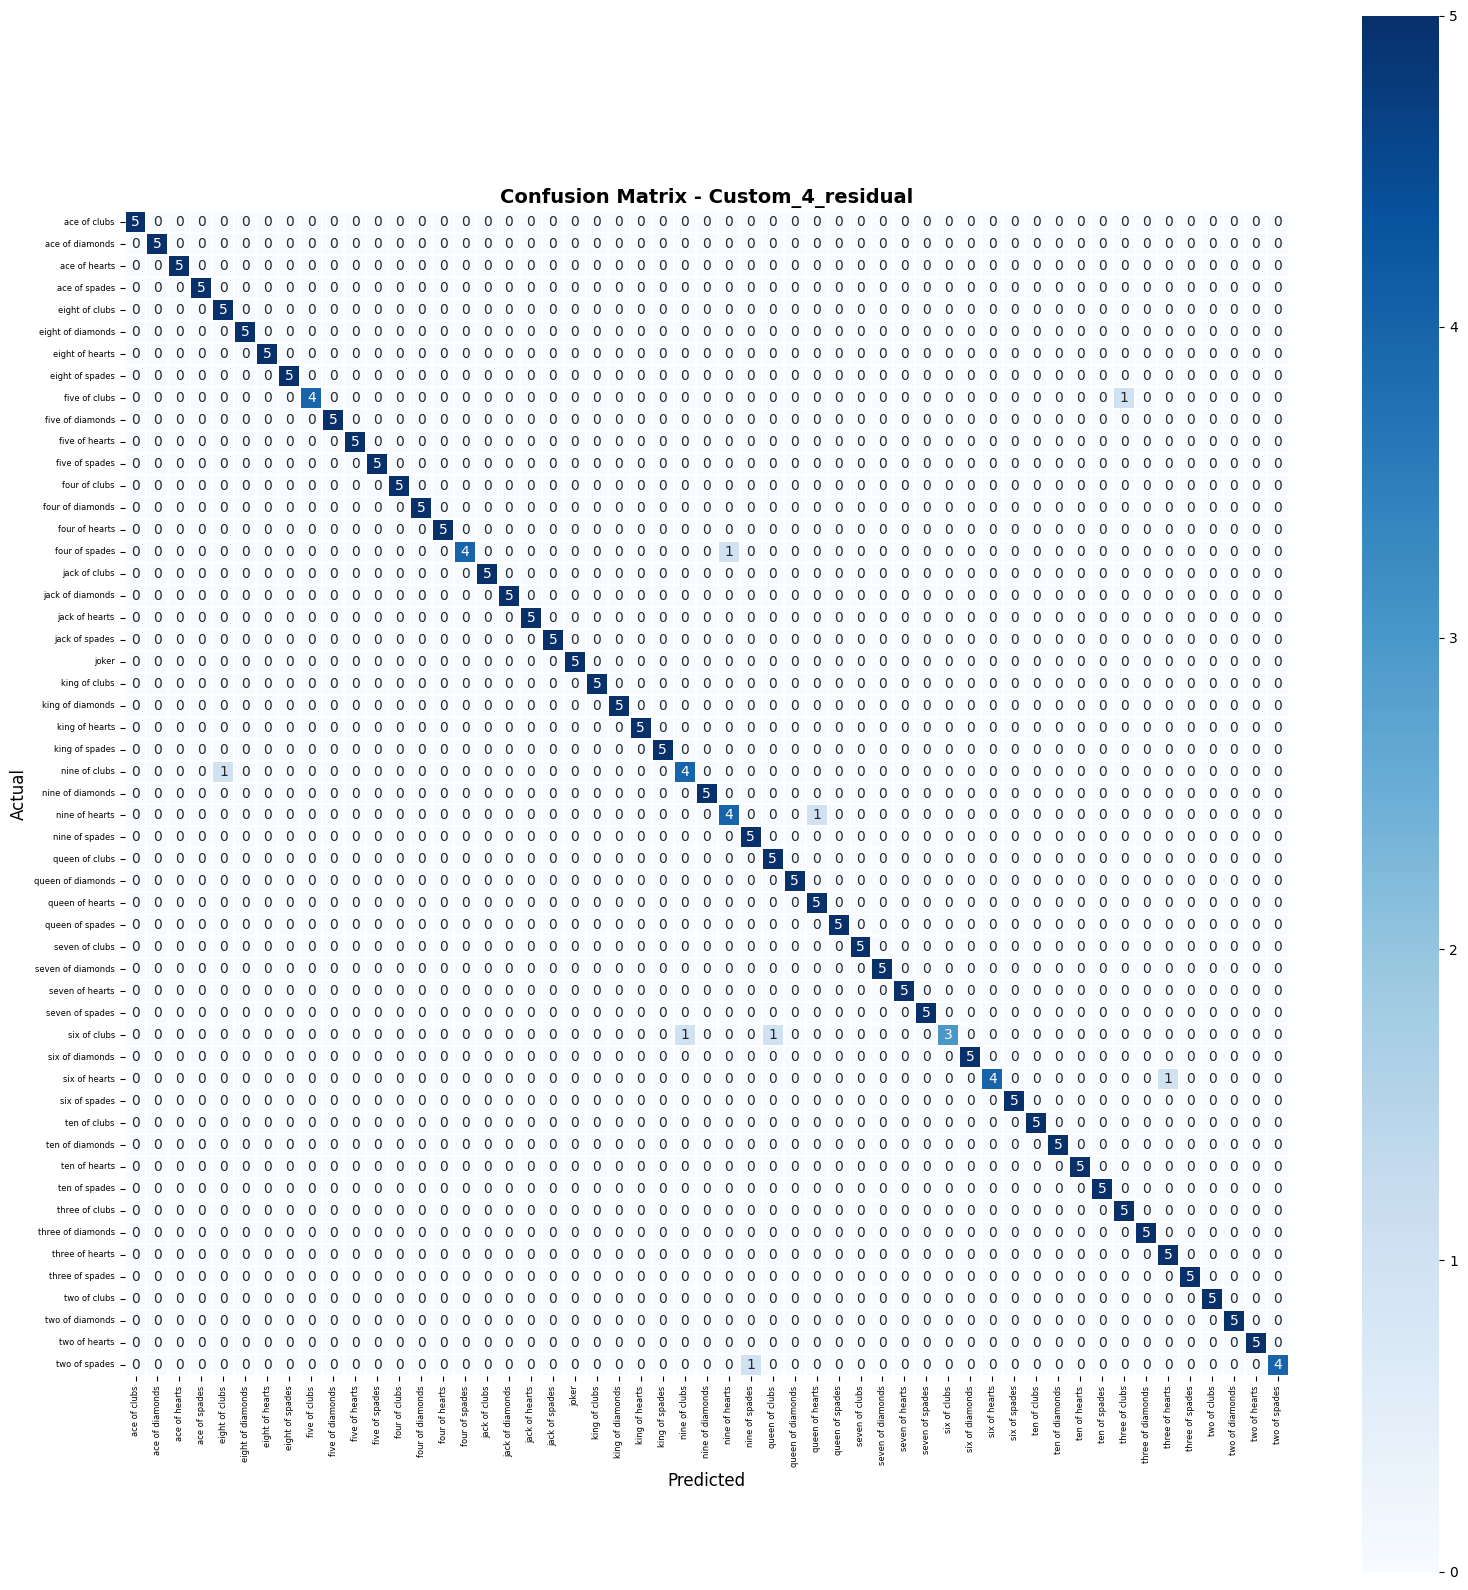

In [27]:
show_matrix(best_model, test_dataset, best_name)

## Comparación visual de todos los modelos

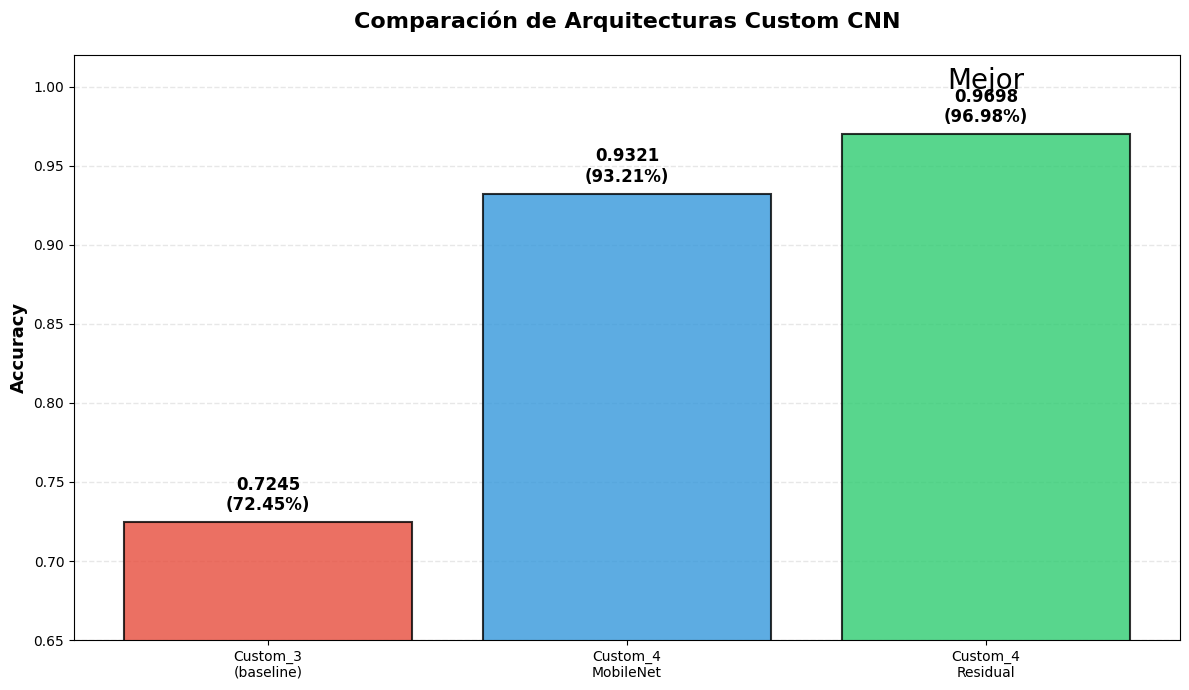


RESUMEN DE MEJORAS
Baseline (Custom_3):        0.7245
MobileNet-style mejora:     +20.75%
Residual CNN mejora:        +24.53%
Mejor modelo:               Custom_4_residual
Accuracy final:             0.9698 (96.98%)


In [28]:
# Gráfico comparativo de todos los modelos custom
models_dict = {
    'Custom_3\n(baseline)': acc_original,
    'Custom_4\nMobileNet': acc_mobilenet,
    'Custom_4\nResidual': acc_residual
}

fig, ax = plt.subplots(figsize=(12, 7))
colors = ['#e74c3c', '#3498db', '#2ecc71']
bars = ax.bar(models_dict.keys(), models_dict.values(), color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Comparación de Arquitecturas Custom CNN', fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(0.65, max(models_dict.values()) + 0.05)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
ax.set_axisbelow(True)

# Añadir valores sobre las barras
for bar, (name, acc) in zip(bars, models_dict.items()):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{acc:.4f}\n({acc*100:.2f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Marcar el mejor con una estrella
    if acc == best_acc:
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.025,
                'Mejor', ha='center', va='bottom', fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(path_results, 'custom_models_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

# Mostrar mejoras
print(f'\n{"="*60}')
print('RESUMEN DE MEJORAS')
print(f'{"="*60}')
print(f'Baseline (Custom_3):        {acc_original:.4f}')
print(f'MobileNet-style mejora:     {mejora_mob:+.2f}%')
print(f'Residual CNN mejora:        {mejora_res:+.2f}%')
print(f'Mejor modelo:               {best_name}')
print(f'Accuracy final:             {best_acc:.4f} ({best_acc*100:.2f}%)')
print(f'{"="*60}')